In [45]:

# do basic imports
import numpy as np
import pandas as pd
import datetime
from sklearn import preprocessing
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
from scipy.sparse import csr_matrix
import scipy as sp
# Packages for visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#wod cloud
from PIL import Image
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_style('dark')
%matplotlib inline

In [46]:
# load data
genome_scores = pd.read_csv('genome_scores.csv')
genome_tags = pd.read_csv('genome_tags.csv')
imdb_data = pd.read_csv('imdb_data.csv')
links = pd.read_csv('links.csv')
movies = pd.read_csv('movies.csv')
tags = pd.read_csv('tags.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

#### View the dataframes loaded

## Genome scores and tags

In [47]:
genome_scores.head()

,movieId,tagId,relevance
0,1,1,0.02875
1,1,2,0.02375
2,1,3,0.06250
3,1,4,0.07575
4,1,5,0.14075


In [48]:
# check length 
len(genome_scores)

15584448

In [49]:
genome_tags.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [50]:
len(genome_tags)

1128

# IMDB data

In [51]:
imdb_data.head(2)

,movieId,title_cast,director,runtime,budget,plot_keywords
0,1,Tom Hanks|Tim Allen|Don Rickles|Jim Varney|Wal...,John Lasseter,81.0,"$30,000,000",toy|rivalry|cowboy|cgi animation
1,2,Robin Williams|Jonathan Hyde|Kirsten Dunst|Bra...,Jonathan Hensleigh,104.0,"$65,000,000",board game|adventurer|fight|game


In [52]:
len(imdb_data['movieId'])

27278

## Links and Movies

In [53]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [54]:
len(links['movieId'])

62423

In [55]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [56]:
len(movies['movieId'])

62423

## Tags

In [57]:
tags.head()

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


In [58]:
len(tags['movieId'])

1093360

# Train and test

In [59]:
train.head()

,userId,movieId,rating,timestamp
0,5163,57669,4.0,1518349992
1,106343,5,4.5,1206238739
2,146790,5459,5.0,1076215539
3,106362,32296,2.0,1423042565
4,9041,366,3.0,833375837


In [60]:
len(train)

10000038

In [108]:
i=0
for x in train.columns:
    if '' in sorted(train[x].unique()):
        i+=1
print('The data contains '+str(i)+' empty values over all columns')

The data contains 0 empty values over all columns


The data contains 0 empty values over all columns
None of our columns contain any null or empty values.



Checking for duplicate values in the dataset using the .duplicated which returns a boolean Series denoting duplicate rows

In [109]:
# Store dDuplications
val_bool = train.duplicated(['userId', 'movieId', 'rating'])

# Show Duplications
print("Number of duplicated values:", sum(val_bool))

Number of duplicated values: 0


In [61]:
test.head()

,userId,movieId
0,1,2011
1,1,4144
2,1,5767
3,1,6711
4,1,7318


In [62]:
len(test)

5000019

## Merge train with movies

In [63]:
train_movies = pd.merge(train, movies, on='movieId')

### EDA on train_movies

In [105]:
# Create dataframe containing only the movieId and genres
movies_genres = pd.DataFrame(movies[['movieId', 'genres']],
                             columns=['movieId', 'genres'])

# Split genres seperated by "|" and create a list containing the genres allocated to each movie
movies_genres.genres = movies_genres.genres.apply(lambda x: x.split('|'))

# Create expanded dataframe where each movie-genre combination is in a seperate row
movies_genres = pd.DataFrame([(tup.movieId, d) for tup in movies_genres.itertuples() for d in tup.genres],
                             columns=['movieId', 'genres'])


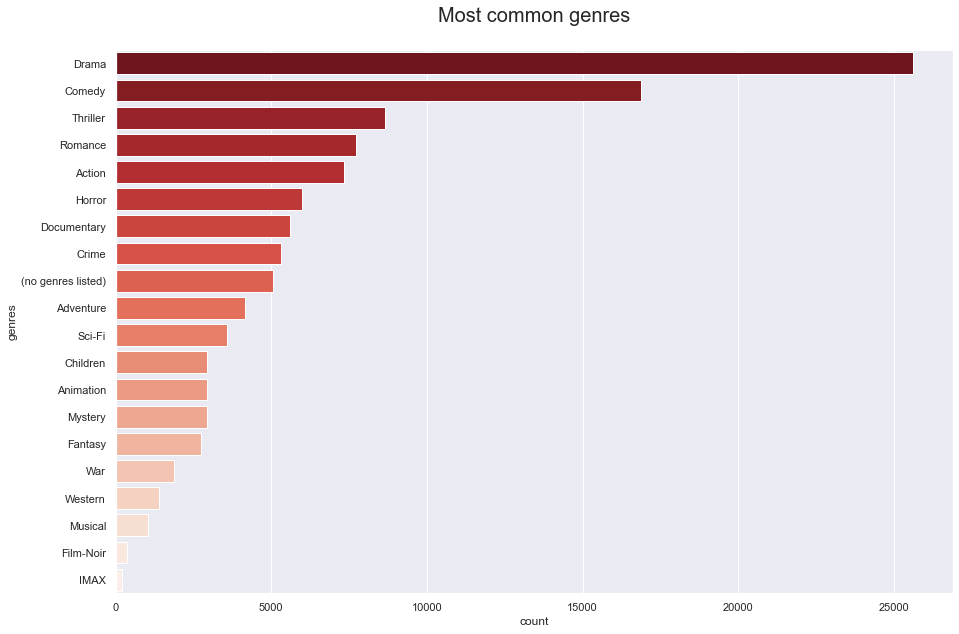

In [106]:
# Plot the genres from most common to least common
plot = plt.figure(figsize=(15, 10))
plt.title('Most common genres\n', fontsize=20)
sns.countplot(y="genres", data=movies_genres,
              order=movies_genres['genres'].value_counts(ascending=False).index,
              palette='Reds_r')
plt.show()

In [64]:
# check the length of train_movies
len(train_movies)

10000038

In [65]:
# check for null values
train_movies.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
title        0
genres       0
dtype: int64

In [66]:
# display last 5 rows of train_movies
train_movies.tail()

,userId,movieId,rating,timestamp,title,genres
10000033,84146,107912,3.0,1389449965,"Fallen, The (2004)",Action|Drama|War
10000034,72315,190143,2.5,1567628158,Formentera Lady,(no genres listed)
10000035,131116,206347,3.0,1568558126,Nocturne (1946),Crime|Drama|Mystery
10000036,85757,196867,3.5,1563175258,Guys & Balls (2004),Comedy|Romance
10000037,72315,97148,3.0,1567584197,Elia Kazan: A Director's Journey (1995),Documentary


In [67]:
# top 20 movies based on their ratings
train_movies.groupby('title')['rating'].mean().sort_values(ascending=False).head(20)

title
Which Way Home (2009)                                       5.0
Kaakha Kaakha (2003)                                        5.0
Not Quite Human II (1989)                                   5.0
Selling Isobel (2018)                                       5.0
Sehar (2005)                                                5.0
The Enchanted Sedan Chair (1905)                            5.0
K.G.F: Chapter 1 (2018)                                     5.0
Hard Cash (2002)                                            5.0
Everyone's Going to Die (2013)                              5.0
Anything for Love (2016)                                    5.0
Chain of Command (2015)                                     5.0
A Killing in a Small Town (1990)                            5.0
Political Animals (2016)                                    5.0
Kabir Singh (2019)                                          5.0
Everything Is Terrible! Presents: The Great Satan (2017)    5.0
Yamadonga (2007)                  

In [68]:
# Top 20 movies that were rated the most
train_movies.groupby('title')['rating'].count().sort_values(ascending=False).head(20)

title
Shawshank Redemption, The (1994)                                                  32831
Forrest Gump (1994)                                                               32383
Pulp Fiction (1994)                                                               31697
Silence of the Lambs, The (1991)                                                  29444
Matrix, The (1999)                                                                29014
Star Wars: Episode IV - A New Hope (1977)                                         27560
Jurassic Park (1993)                                                              25518
Schindler's List (1993)                                                           24004
Braveheart (1995)                                                                 23722
Fight Club (1999)                                                                 23536
Terminator 2: Judgment Day (1991)                                                 23075
Toy Story (1995)          

In [69]:
#create a dataframe for analysis
num_of_ratings = pd.DataFrame(train_movies.groupby('title')['rating'].mean().sort_values(ascending=False))
num_of_ratings['total number of ratings'] = pd.DataFrame(train_movies.groupby('title')['rating'].count()) 

In [70]:
num_of_ratings.head(5)

,rating,total number of ratings
title,,
Which Way Home (2009),5.0,1
Kaakha Kaakha (2003),5.0,1
Not Quite Human II (1989),5.0,1
Selling Isobel (2018),5.0,1
Sehar (2005),5.0,1


Let's create a new dataframe also containing the `title`, `rating` and `total number of ratings`, but this time we will sort by the `total number of ratings`.

In [71]:
#create a dataframe for analysis
new_trend = pd.DataFrame(train_movies.groupby('title')['rating'].mean())
new_trend['total number of ratings'] = pd.DataFrame(train_movies.groupby('title')['rating'].count())

In [72]:
# sort dataframe by total number of ratings
new_trend.sort_values(by=['total number of ratings'], inplace=True, ascending=False)
# reset the index
new_trend.reset_index(inplace=True)

In [73]:
new_trend.head()

,title,rating,total number of ratings
0,"Shawshank Redemption, The (1994)",4.417624,32831
1,Forrest Gump (1994),4.047216,32383
2,Pulp Fiction (1994),4.195097,31697
3,"Silence of the Lambs, The (1991)",4.144172,29444
4,"Matrix, The (1999)",4.154253,29014


<AxesSubplot:xlabel='total number of ratings', ylabel='title'>

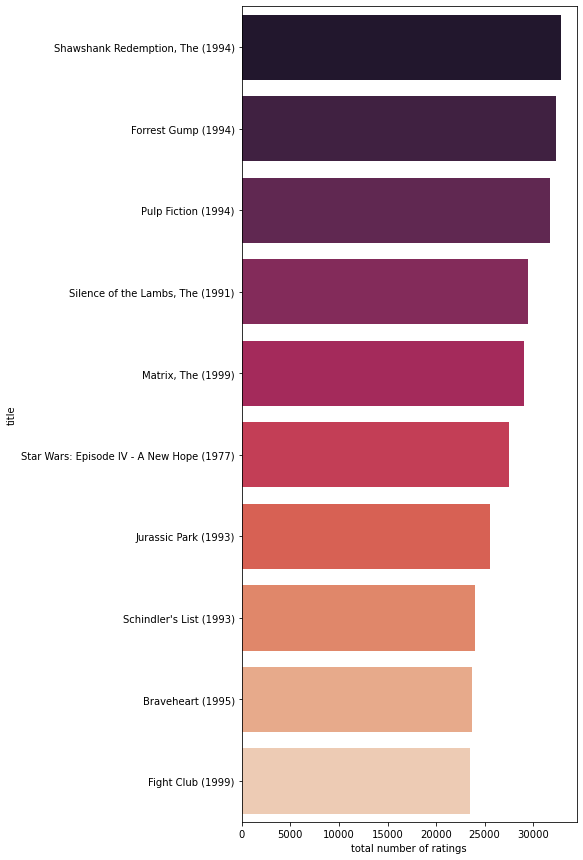

In [74]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))

sns.barplot(x="total number of ratings", y="title", data=new_trend.head(10), palette='rocket')

Text(0.5, 1.0, 'Distribution of Ratings')

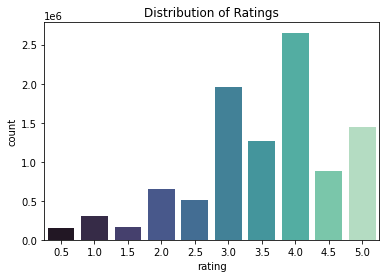

In [75]:
# plot distribution of ratings
sns.countplot(x = 'rating', data = train_movies, palette="mako")
plt.title("Distribution of Ratings")
#flare
#crest
#magma
#viridis
#rocket_r

In [76]:
#create a dataframe for analysis
user_id = pd.DataFrame(train_movies.groupby('userId')['rating'].mean())
user_id['total number of ratings'] = pd.DataFrame(train_movies.groupby('userId')['rating'].count())

In [77]:
user_id.head()

,rating,total number of ratings
userId,,
1,3.910714,28
2,3.416667,72
3,3.691235,251
4,3.308989,89
5,3.885714,35


In [78]:
# sort dataframe by total number of ratings
user_id.sort_values(by=['total number of ratings'], inplace=True, ascending=False)
# reset the index
user_id.reset_index(inplace=True)

In [79]:
user_id.head(10)

,userId,rating,total number of ratings
0,72315,3.092380,12952
1,80974,3.277582,3680
2,137293,3.192168,3588
3,33844,2.583853,3208
4,20055,3.179016,3050
5,109731,2.830026,2671
6,49403,1.514045,2670
7,92046,3.484296,2579
8,110971,3.764642,2288
9,30879,2.854203,2284


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, '72315'),
  Text(1, 0, '80974'),
  Text(2, 0, '137293'),
  Text(3, 0, '33844'),
  Text(4, 0, '20055'),
  Text(5, 0, '109731'),
  Text(6, 0, '49403'),
  Text(7, 0, '92046'),
  Text(8, 0, '110971'),
  Text(9, 0, '30879')])

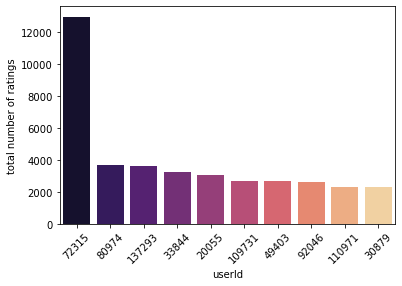

In [80]:
#total number of ratings per user id
sns.barplot(y="total number of ratings", x="userId", data=user_id.head(10), 
            order = user_id.head(10).sort_values('total number of ratings', ascending=False).userId, palette='magma')
plt.xticks(rotation=45)

In [81]:
imdb_data.dropna(inplace=True)

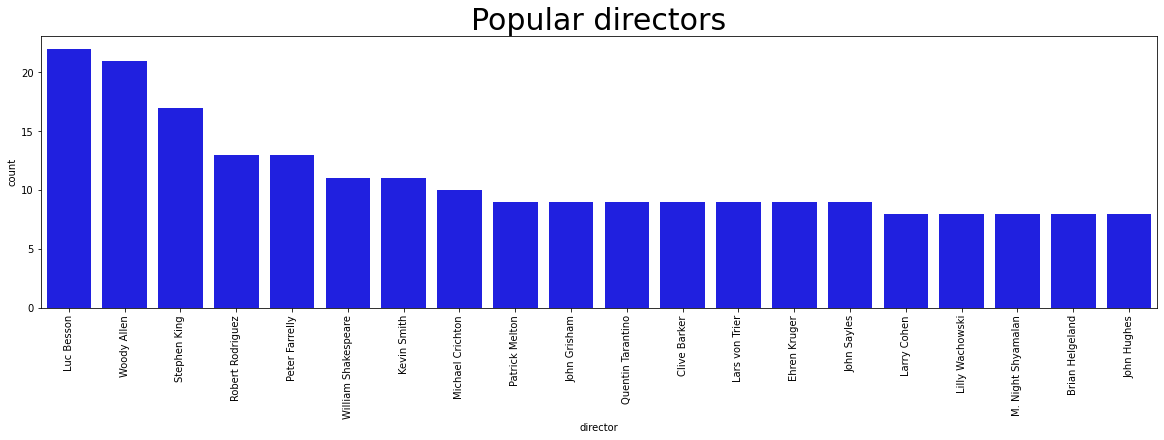

In [82]:
# Plot popular directors
plt.figure(figsize = (20,5))
directors=imdb_data['director'].explode()
ax=sns.countplot(x=directors, order = directors.value_counts().index[:20],color='blue')
ax.set_title('Popular directors',fontsize=30)
plt.xticks(rotation=90)
plt.show()

In [83]:
#create a dataframe for analysis
ratings_trend = pd.DataFrame(train_movies.groupby('movieId')['rating'].mean())
ratings_trend['total number of ratings'] = pd.DataFrame(train_movies.groupby('movieId')['rating'].count()) 
ratings_trend.head(10)

,rating,total number of ratings
movieId,,
1,3.889971,23062
2,3.263414,9654
3,3.132325,4727
4,2.878099,968
5,3.059165,4648
6,3.857906,9828
7,3.381459,4838
8,3.052209,498
9,3.010533,1519


In [84]:
#create a dataframe for analysis
new_trend = pd.DataFrame(train_movies.groupby('title')['rating'].mean())
new_trend['total number of ratings'] = pd.DataFrame(train_movies.groupby('title')['rating'].count())

In [85]:
# sort dataframe by total number of ratings
new_trend.sort_values(by=['total number of ratings'], inplace=True, ascending=False)
# reset the index
new_trend.reset_index(inplace=True)

<AxesSubplot:xlabel='total number of ratings', ylabel='title'>

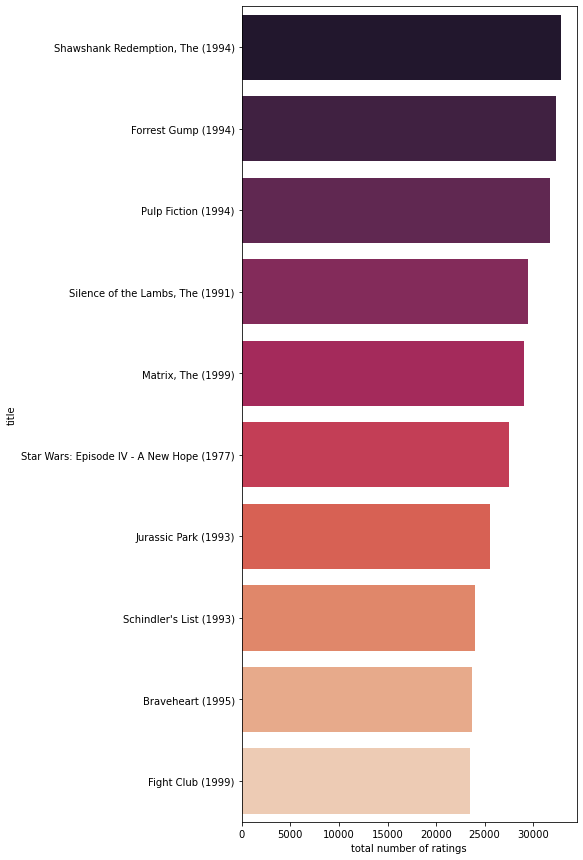

In [86]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))

sns.barplot(x="total number of ratings", y="title", data=new_trend.head(10), palette='rocket')

In [87]:
# Create dataframe containing only the movieId and keywords
imdb_keywords = pd.DataFrame(imdb_data[['movieId', 'plot_keywords']],
                             columns=['movieId', 'plot_keywords'])

# Split genres seperated by "|" and create a list containing the genres allocated to each movie
imdb_keywords.plot_keywords = imdb_keywords.plot_keywords.apply(lambda x: x.split('|'))

# Create expanded dataframe where each movie-genre combination is in a seperate row
imdb_keywords = pd.DataFrame([(tup.movieId,d) for tup in imdb_keywords.itertuples() for d in tup.plot_keywords],
                             columns=['movieId', 'plot_keywords'])

imdb_keywords.head()

,movieId,plot_keywords
0,1,toy
1,1,rivalry
2,1,cowboy
3,1,cgi animation
4,2,board game


In [88]:
# Create dataframe containing only the movieId and title_casts
imdb_casts = pd.DataFrame(imdb_data[['movieId', 'title_cast']],
                             columns=['movieId', 'title_cast'])

# Split title_casts seperated by "|" and create a list containing the title_cast allocated to each movie
imdb_casts.title_cast = imdb_casts.title_cast.apply(lambda x: x.split('|'))

# Create expanded dataframe where each movie-title_cast combination is in a seperate row
imdb_casts = pd.DataFrame([(tup.movieId, d) for tup in imdb_casts.itertuples() for d in tup.title_cast],
                             columns=['movieId', 'title_cast'])

imdb_casts.head()

,movieId,title_cast
0,1,Tom Hanks
1,1,Tim Allen
2,1,Don Rickles
3,1,Jim Varney
4,1,Wallace Shawn


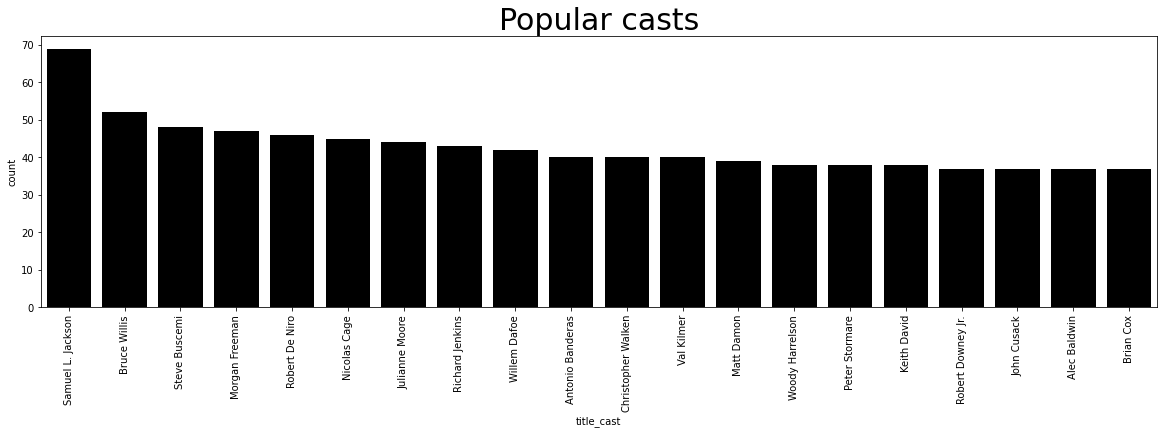

In [89]:
# Plot popular casts
plt.figure(figsize = (20,5))
casts=imdb_casts['title_cast'].explode()
ax=sns.countplot(x=casts, order = casts.value_counts().index[:20],color='black')
ax.set_title('Popular casts',fontsize=30)
plt.xticks(rotation=90)
plt.show()

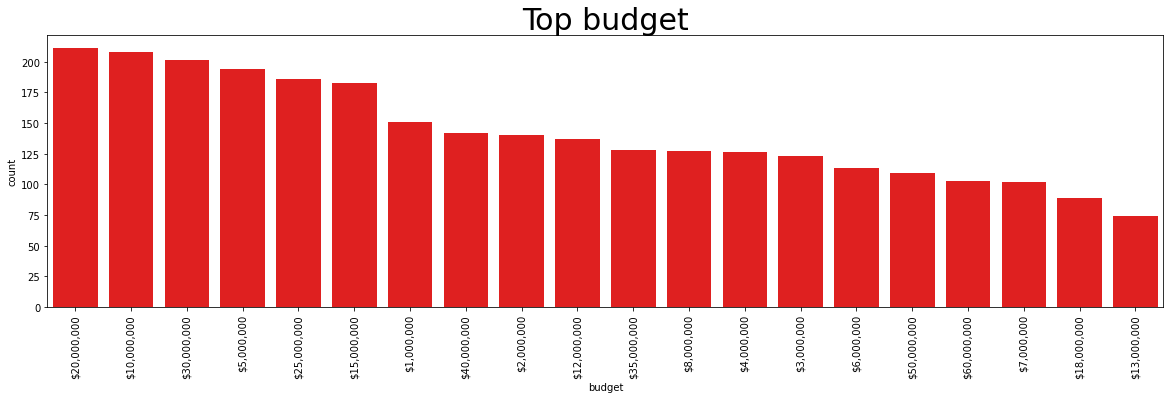

In [90]:
#budget
plt.figure(figsize = (20,5))
budget=imdb_data['budget'].explode()
ax=sns.countplot(x=budget, order = budget.value_counts().index[:20],color='red')
ax.set_title('Top budget',fontsize=30)
plt.xticks(rotation=90)
plt.show()


<AxesSubplot:>

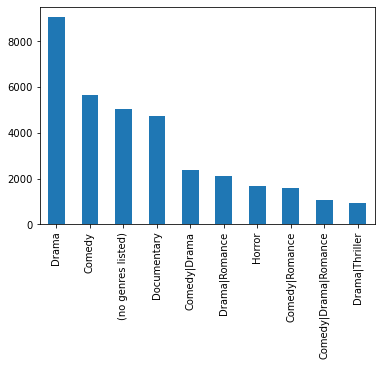

In [94]:
movies['genres'].value_counts()[:10].plot(kind='bar')

We are abe to visualise that Drama is the leading genre and drama|Thriller is the least most watched genre

<AxesSubplot:>

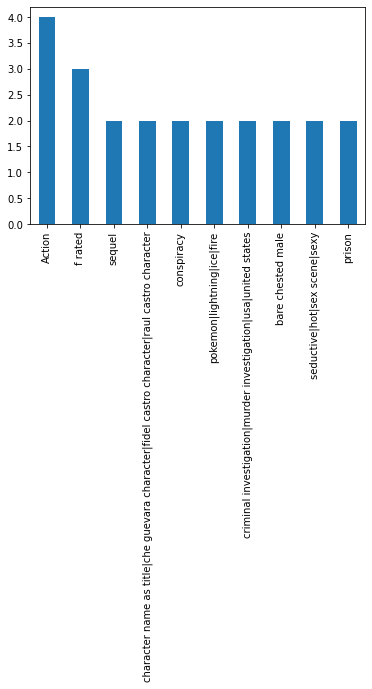

In [95]:
imdb_data['plot_keywords'].value_counts()[:10].plot(kind='bar')

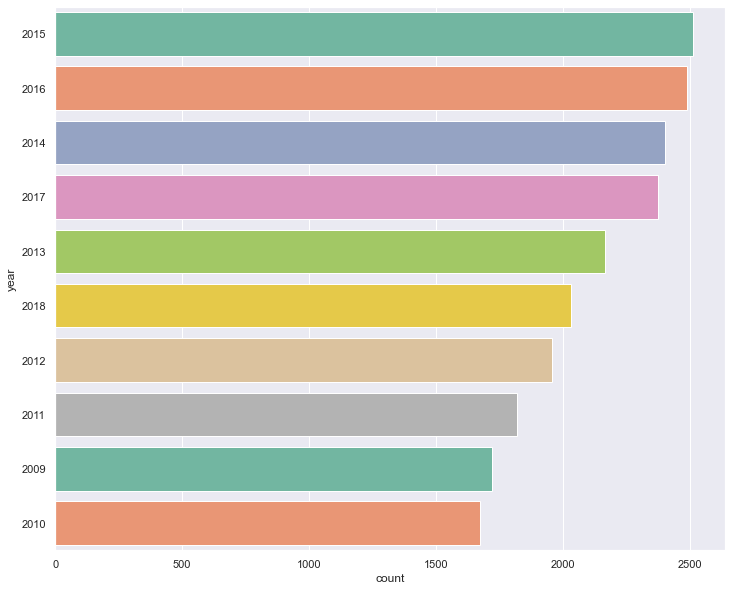

In [98]:
movies['y'] = movies['title'].str.split(' ')
movies['year'] = movies['y'].apply(lambda x: x[-1])
movies['year'] = movies['year'].str.strip(')')
movies['year'] = movies['year'].str.strip('(')
# lets drop the unnecessary 'y' column from the dataset
movies = movies.drop(['y'], axis = 1)
plt.figure(figsize=(12,10))
sns.set(style="darkgrid")
ax = sns.countplot(y="year", data=movies, palette="Set2", order=movies['year'].value_counts().index[0:10])

We are able to visualise that 2015 had the most movies in our dataset

In [101]:
data = pd.merge(movies, imdb_data, on = 'movieId', how = 'inner')
##As we do not Require the MovieId, title_cast, director and plot_keywords lets remove them
data = data.drop(['movieId', 'title_cast', 'director','plot_keywords'], axis = 1)
##Realised that budget has different currencies.Dont know how to work through that
sortedbudget= data.sort_values(['budget'], ascending=False
       
plt.figure(figsize=(12,6))
sns.distplot(data[(data['runtime'] < 300) & (data['runtime'] > 0)]['runtime'])                               

SyntaxError: invalid syntax (<ipython-input-101-02e2e6ee745f>, line 7)

In [102]:
seperate_genre='Drama','Comedy','Documentary','Comedy|Drama','Drama|Romance'
for genre in seperate_genre:
    df = data['genres'].str.contains(genre).fillna(False)
    print('The total number of movies with ',genre,'=',len(data[df]))
    f, ax = plt.subplots(figsize=(20, 12))
    sns.countplot(x='year', data=data[df], palette="Greens_d");
    plt.title(genre)

NameError: name 'data' is not defined

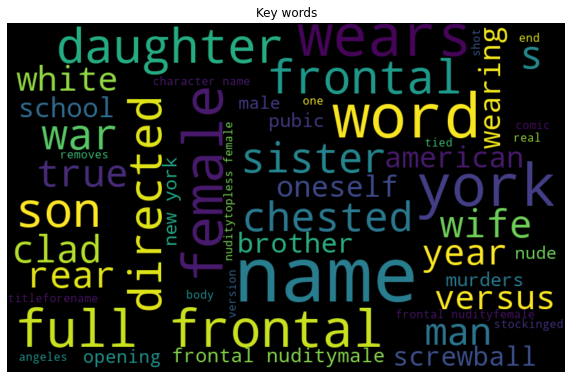

In [91]:
#word cloud for key words that people use while searching
all_words = ''.join([label for label in imdb_keywords['plot_keywords']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, max_words=50).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Key words')

plt.show()

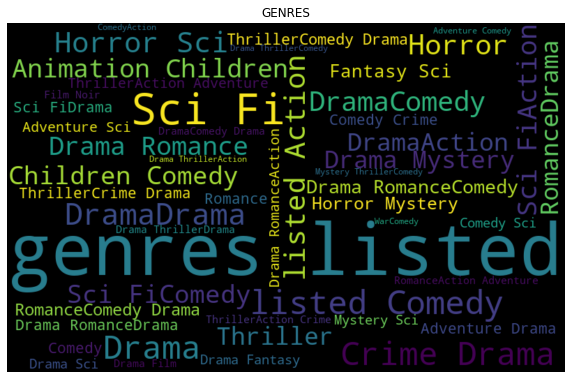

In [92]:
#word cloud for genre

all_words = ''.join([label for label in movies['genres']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, max_words=50).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('GENRES')

plt.show()

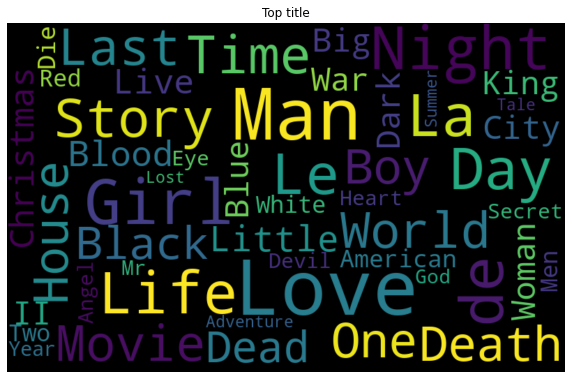

In [93]:
#word cloud for top title
from wordcloud import WordCloud
all_words = ''.join([label for label in movies['title']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110, max_words=50).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top title')

plt.show()